In [1]:
from test_hmmbatchcd import *

# 3 Tests

terminated early - convergence
Hamming Distance =  0.0


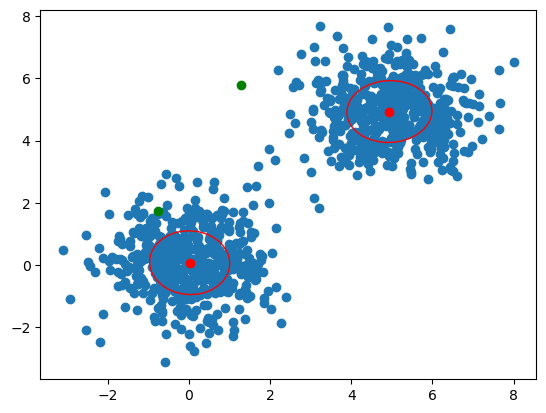

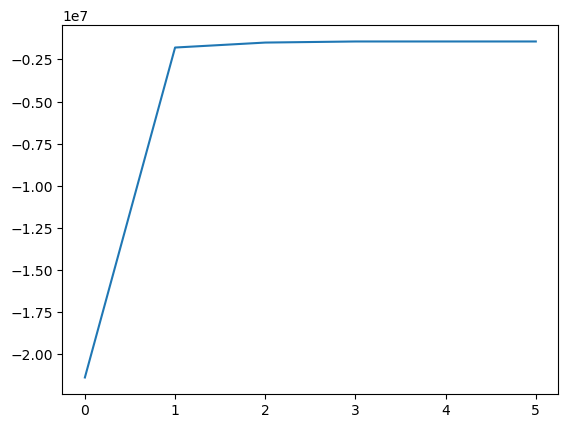

terminated early - convergence
Hamming Distance =  0.0


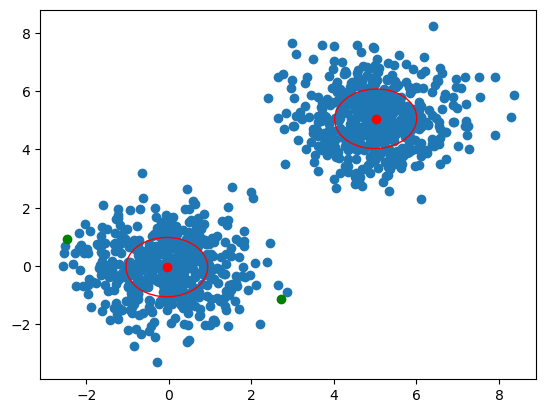

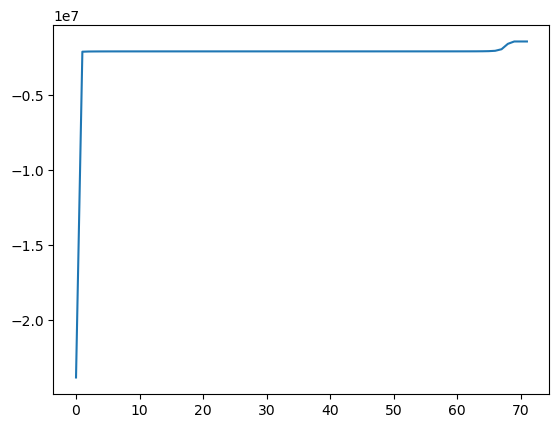

terminated early - convergence
Hamming Distance =  0.0


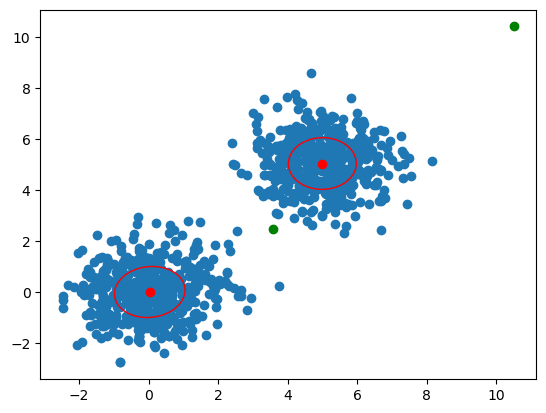

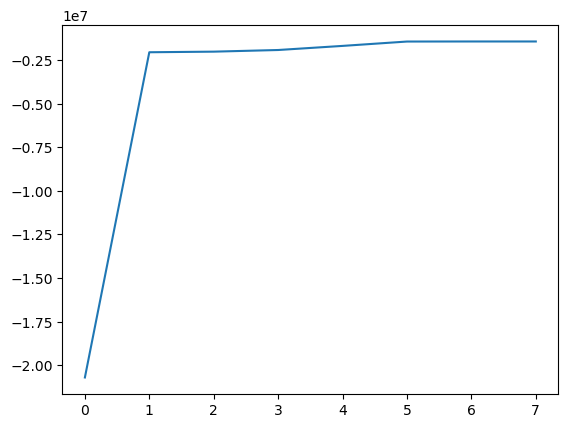

In [3]:
for i in range(3):
    test_hmmbatchcd()

### Interactive testing with comparision

ToDO  - finish this section

terminated early - convergence
Hamming Distance =  0.0


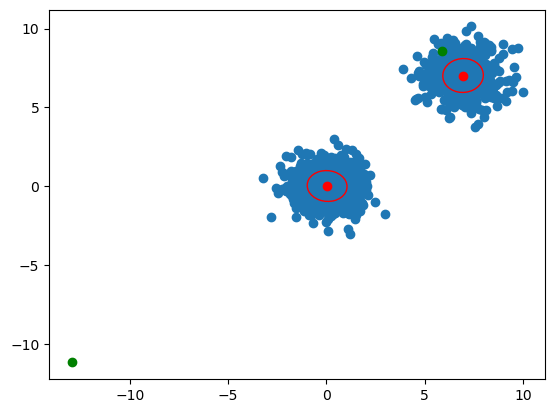

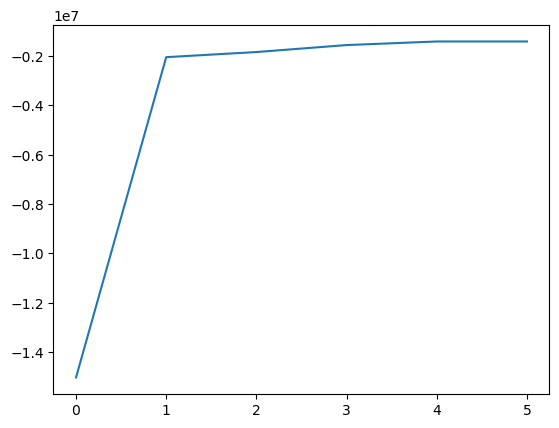

In [2]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


# generating toy data using emissions (in 2 dimensions)

K = 2           # number of states  
D = K           #have to be equal (symmetry)
kappa_0 = 0.1     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

# define priors on emission to be multivariate gaussian with 0 mean and unit var (no covariance)
emit1 = Gaussian(mu=np.array([0,0]),
                    sigma=np.eye(2),
                    mu_0=np.zeros(2),
                    sigma_0=np.eye(2),
                    kappa_0=kappa_0,
                    nu_0=nu_0)
emit2 = Gaussian(mu=np.array([7,7]),    # distance of blobs
                    sigma=np.eye(2),    # variance of blobs
                    mu_0=np.zeros(2),   # prior
                    sigma_0=np.eye(2),  # prior
                    kappa_0=kappa_0,    # prior
                    nu_0=nu_0)          # prior
emit = np.array([emit1, emit2])

# generate observations
N = 1000
obs = np.array([emit[int(np.round(i/N))].rvs()[0]
                for i in range(N)])

# set priors on emissions to be 0 mean  
# 0.75 frac of empirical covariance matrix

mu_0 = np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 0.5
nu_0 = 4

# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for _ in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit,maxit=10000, epsilon=10**(-10))  
hmm.infer() # do inference 

sts_true = np.array([int(np.round(i/N)) for i in range(N)]) # true states 
# hamming distance
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

## Jack's and Ben's code from stan analysis

In [ ]:
import stan
import numpy as np
import nest_asyncio
nest_asyncio.apply()

In [32]:
dat = [tuple(i) for  i in obs]
data = {'y':dat , "N": N, "D":2, "K":2, 'mu_0':mu_0 , 'kappa_0':kappa_0, 'nu_0':nu_0,'Psi_0':sigma_0,'alpha_0':np.ones((K,D))} #specify dirichlet prior [1,1,1,...] on transitions

In [96]:
# read code from .stan file 
with open('BenJackCode/MvNormEmis_HMM.stan') as f:
    stan_code = f.read()

# build stan model 
jack_model = stan.build(stan_code,data)

N_MCMC = 1000 

# start sampling
fit = jack_model.sample(num_chains = 1, num_samples = 1000+N_MCMC, num_warmup = 1000 )

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 50: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 10, column 62: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/var/folders/7p/d4w3jgwj0251x3606r7hxj4h0000gn/T/httpstan_56a2ctxi/model_bggfrf6v.stan', line 11, column 26: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Ins

In [43]:
fit

<stan.Fit>
Parameters:
    mu: (2, 2)
    Sigma: (2, 2, 2)
    gamma: (2, 2)
Draws: 2000

In [82]:
fit['mu'][1].T

array([[ 0.03641193,  0.02987108],
       [ 0.11585252,  0.0088157 ],
       [-0.01902489,  0.01773381],
       ...,
       [ 0.03349832,  0.03429669],
       [ 0.03509429,  0.00450186],
       [ 0.02224409,  0.10425809]])

In [83]:
fr = pd.DataFrame(fit['mu'][0].T, columns = ['state 1 x1','state 1 x2'])
fr['state 2 x1'],fr['state 2 x2'] = fit['mu'][1]

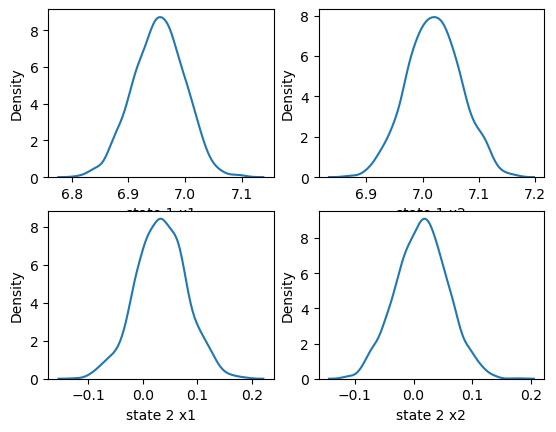

In [95]:
for i, column in enumerate(fr.columns, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(fr[column])
    

## Matrix Expansion 

In [61]:
from matrix_expansion import *
test_matrix_expansion()

This is an example of how conversion HSMM to HMM transition matrix is done with expand_matrix()
The HSMM matrix is :
[[0.  0.8 0.2]
 [0.3 0.  0.7]
 [0.5 0.5 0. ]]
a_js are: [2 2 2]
lambda_js are: [1 2 3]
the 1- h vector is : [0.41802329 0.3038944 ]
the 1- h vector is : [0.68696471 0.54432116]
the 1- h vector is : [0.84281291 0.72024558]
sum of row entries :[1. 1. 1. 1. 1. 1.]
[[0.         0.41802329 0.46558137 0.         0.11639534 0.        ]
 [0.         0.3038944  0.55688448 0.         0.13922112 0.        ]
 [0.09391059 0.         0.         0.68696471 0.2191247  0.        ]
 [0.13670365 0.         0.         0.54432116 0.31897519 0.        ]
 [0.07859354 0.         0.07859354 0.         0.         0.84281291]
 [0.13987721 0.         0.13987721 0.         0.         0.72024558]]
